# ENSO_amplitude: Variability of SST Anomalies in the Central Equatorial Pacific  

Computes the standard deviation of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W) to evaluate the amplitude of variability in the central equatorial Pacific, a key characteristic of ENSO events.  

## Datasets Used for Amplitude Comparison  

The following reference datasets are used to evaluate the amplitude of ENSO-related SST anomalies in model simulations:  
- **HadISST (1870–2018)**: A comprehensive dataset of historical SST and sea ice observations combined with reconstructions.


## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44239,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44403,Total threads: 1
Dashboard: /proxy/46215/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:45797,


## Datasets

In [1]:
from esmvalcore.dataset import Dataset

### Exercise:
Fill in another Dataset definition for ACCESS-CM2 to add to model datasets to also get processed.
Some hints in the comments below

In [4]:
model_datasets = {
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='ts',
#     project='CMIP6',
#     mip="Amon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# ), 
# replace dataset ACCESS-CM2, tos, Omon
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
"ACCESS-CM2": 
    Dataset(
    short_name=, #
    project='CMIP6',
    mip=, #
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset=, #
    grid="gn"
)
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),

}

## Add Ancillary files

### Excerise: update ancillary files to match
For ACCESS-CM2, tos, Omon, **ancillary files** are sftof, areacello in mip= Ofx

This is CMIP vocabulary and as the ancillary files are different we cannot add them to both model datasets of `Amon` and `Omon`

In [5]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [6]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [7]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea


### Excerise: Complete the preprocessing functions to use on the data
 - anomalies [*see api doc*](https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.preprocessor.html#esmvalcore.preprocessor.anomalies) to get monthly anomalies
 - [*regrid*](https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.preprocessor.html#esmvalcore.preprocessor.regrid) using a linear scheme for a 1x1 target grid
 - [*detrend*](https://docs.esmvaltool.org/projects/ESMValCore/en/latest/api/esmvalcore.preprocessor.html#esmvalcore.preprocessor.detrend) time linearly
 - for info on collapsing cube dimension: https://scitools-iris.readthedocs.io/en/stable/generated/api/iris.cube.html#iris.cube.Cube.collapsed

Comments below where to complete

In [8]:
## sst_std for diag 1
def prepoc_one(cube):
    nino34_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = extract_region(cube, **nino34_region)
    cube = anomalies(cube, ) # fill in to get monthly anomalies
    cube = detrend(cube, ) # dimension, method
    cube = area_statistics(cube, operator='mean')
    cube = cube.collapsed(['time'], iris.analysis.STD_DEV)

    return cube

# diag level 2 & 3
def prepoc(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = regrid(cube, ) #target_grid, scheme
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube, ) # fill in
    cube = axis_statistics(cube,axis='y', operator='mean')

    cube = cube.collapsed(['time'], iris.analysis.STD_DEV)
    return cube
    
def prepoc3(cube):
    nino34_latext_region = {"start_longitude": 120., "end_longitude": 280., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land")
    cube = regrid(cube, ) #target_grid, scheme
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube, ) # fill in

    cube = cube.collapsed(['time'], iris.analysis.STD_DEV)
    return cube

def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [9]:
model_datasets_prep = {name: prepoc_one(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc_one(dataset) for name, dataset in obs_datasets.items()}

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

In [ ]:
import iris
import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt

### Exercise
Replace model in 'metric' to add to scatter plot

Text(0.75, 0.8, '* observation')

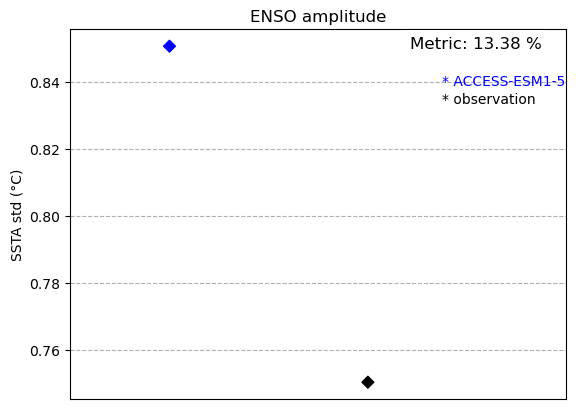

In [10]:
#replace model with ACCESS-CM2
metric = [model_datasets_prep["ACCESS-ESM1-5"].data.item(), obs_datasets_prep["HadISST"].data.item()]


plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)
plt.xticks([])

plt.ylabel('SSTA std (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO amplitude')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)


Figure 1: Standard deviation of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), representing the amplitude of variability. The model amplitude is typically close to the reference but slightly weaker. Black markers indicate the reference data, while blue markers represent the model. The derived metric is the absolute relative difference, calculated as: 
abs
(
(
model
−
ref
)
/
ref
)
×
100
abs((model−ref)/ref)×100.

## Diagnostic Level 2

The second level shows the zonal structure of the ENSO amplitude: the standard deviation of the anomalies along the equator in the Pacific.

In [11]:
## preprocess datasets as needed for level 2 diagnostic
model_datasets_prep2 = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}


In [ ]:
## diag 2 plot
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

### Excerise:
Plot model line for ACCESS-CM2 and label correctly

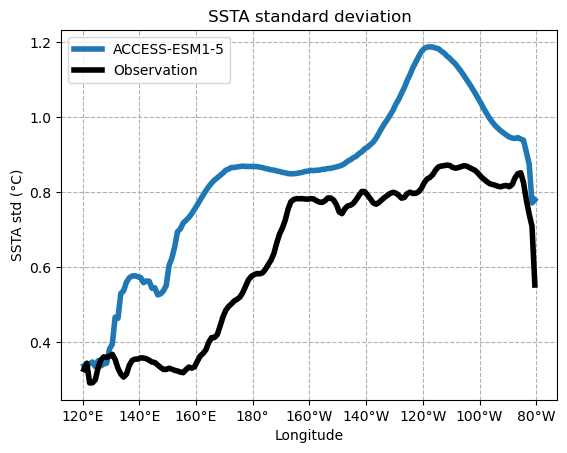

In [13]:
#access-CM2
qplt.plot(model_datasets_prep2["ACCESS-ESM1-5"], label="ACCESS-ESM1-5", linewidth=4)


qplt.plot(obs_datasets_prep2["HadISST"], color='black', label='Observation', linewidth=4)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.grid(linestyle='--')
plt.legend()


Figure 2: Zonal structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N). The figure highlights the model's tendency to overestimate maximum variability in the central equatorial Pacific and west of the dateline. The black curve represents the reference data, while the blue curve corresponds to the model output.

## Diagnostic level 3

This dive down level plots the SST standard deviation spatially in the equatorial Pacific

In [14]:
## preprocess datasets as needed for level 3 diagnostic
model_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in obs_datasets.items()}

In [ ]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

### Exercise:
Change the model dataset to compare ACCESS-CM2 to observation

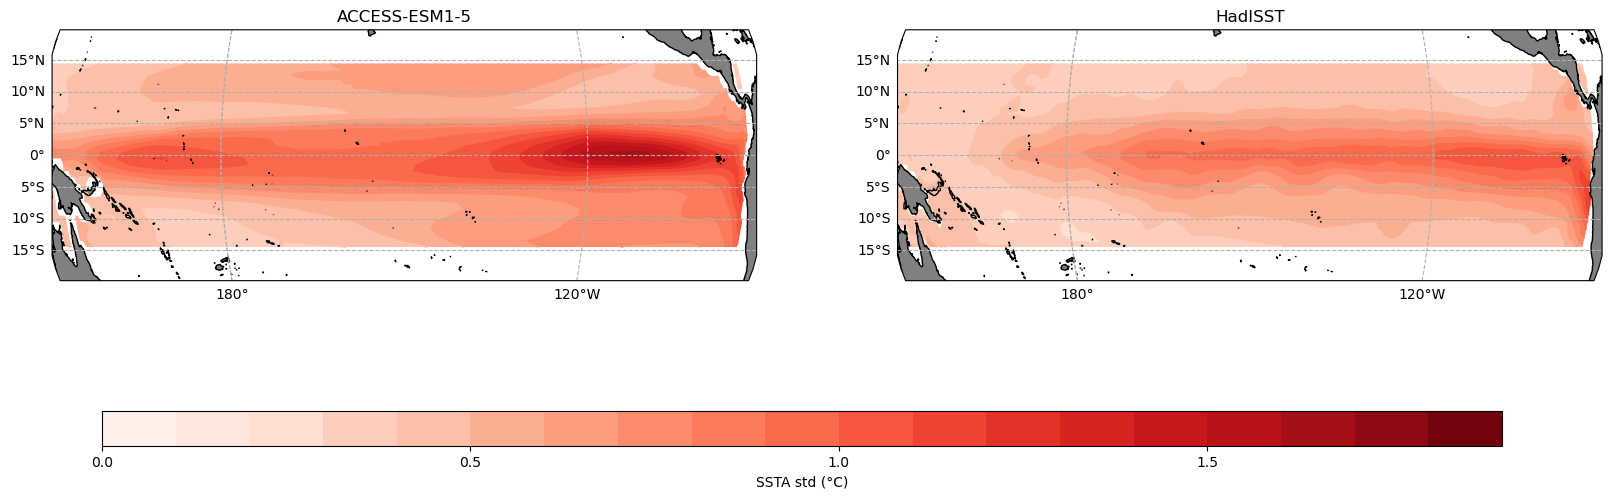

In [15]:
fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121

process = {"ACCESS-ESM1-5":model_datasets_prep3["ACCESS-ESM1-5"], "HadISST":obs_datasets_prep3["HadISST"]}

### change model dataset.. # ACCESS-CM2 ###
process = {, "HadISST":obs_datasets_prep3["HadISST"]}

for label, cube in process.items(): #duplicate another comparison
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,2,0.1), cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,2,0.5))
cbar.set_label('SSTA std (°C)')

Figure 3: spatial structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Pacific, showing usually a too weak variability off South America, a too strong maximum variability in the central equatorial Pacific and a too strong variability west of the dateline. The left and right maps show respectively the reference and the model.

In [ ]:
client.close()